# Рекомендация тарифов

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Various_smartphones_-_Android%2C_Blackberry%2C_Windows_Phone%2C_and_iOS.jpg/640px-Various_smartphones_-_Android%2C_Blackberry%2C_Windows_Phone%2C_and_iOS.jpg 'Carlos Varela')

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф.

Построим модель с максимально большим значением метрики *accuracy*.

## Загрузка и изучение данных

Загрузим файл с данными и посмотрим на них повнимательнее.

In [60]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

import seaborn as sns
import matplotlib.pyplot as plt

In [61]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (15, 5)})

In [62]:
! gdown 1MKt_QSIC2GvNH1xIUcj6t0VFNjwLUmiV

Downloading...
From: https://drive.google.com/uc?id=1MKt_QSIC2GvNH1xIUcj6t0VFNjwLUmiV
To: /content/users_behavior.csv
100% 134k/134k [00:00<00:00, 77.1MB/s]


In [63]:
df = pd.read_csv('/content/users_behavior.csv')

In [64]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [92]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
calls,3214.0,63.038892,33.236368,0.0,40.0000,62.000,82.0000,244.00
minutes,3214.0,438.208787,234.569872,0.0,274.5750,430.600,571.9275,1632.06
messages,3214.0,38.281269,36.148326,0.0,9.0000,30.000,57.0000,224.00
mb_used,3214.0,17207.673836,7570.968246,0.0,12491.9025,16943.235,21424.7000,49745.73
is_ultra,3214.0,0.306472,0.461100,0.0,0.0000,0.000,1.0000,1.00


In [67]:
df.duplicated().sum()

0

В нашем распоряжении файл с 3214 записями о клиентах. Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
* `сalls` — количество звонков,
* `minutes` — суммарная длительность звонков в минутах,
* `messages` — количество sms-сообщений,
* `mb_used` — израсходованный интернет-трафик в Мб,
* `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

Из вывода команды _df.info()_ видно, что пропусков в данных нет, типы данных определились корректно. Дубликатов данных не найдено. Похоже, что значительной предобработки данных не потребуется.

Познакомимся с данными в отдельных колонках, чтобы лучше понимать, с чем нам придётся работать.

### `calls`

Построим гистограмму распределения и «ящик с усами» для данных из колонки `calls`.

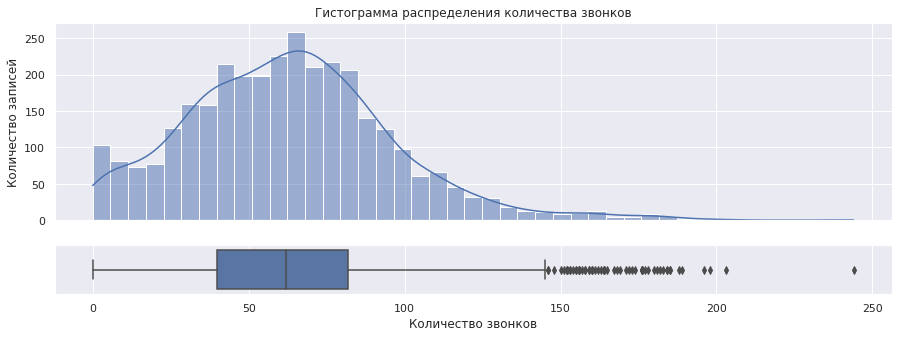

In [68]:
f, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 5), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[4,1]))
sns.histplot(data=df, x='calls', kde=True, ax=axs_hist)\
.set(title='Гистограмма распределения количества звонков',
     ylabel='Количество записей')
sns.boxplot(data=df, x='calls', ax=axs_box)\
.set(xlabel='Количество звонков');

### _minutes_

Построим гистограмму распределения и «ящик с усами» для данных из колонки `minutes`.

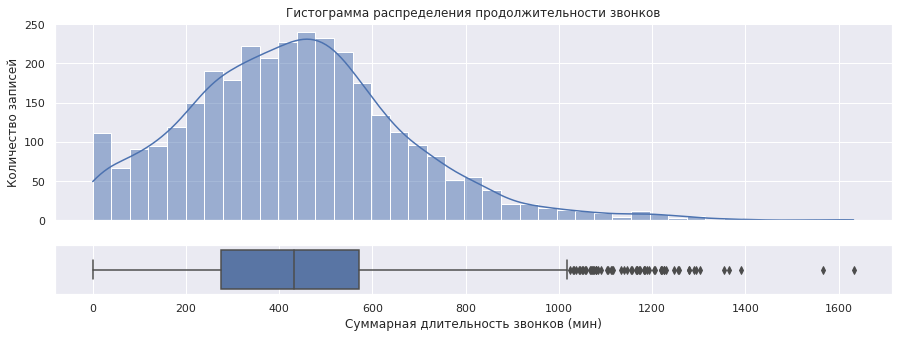

In [69]:
f, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 5), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[4,1]))
sns.histplot(data=df, x='minutes', kde=True, ax=axs_hist)\
.set(title='Гистограмма распределения продолжительности звонков',
     ylabel='Количество записей')
sns.boxplot(data=df, x='minutes', ax=axs_box)\
.set(xlabel='Суммарная длительность звонков (мин)');

### _messages_

Построим гистограмму распределения и «ящик с усами» для данных из колонки `messages`.

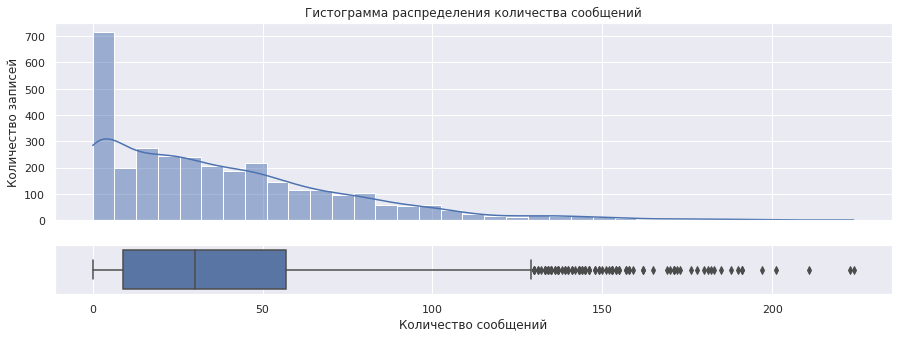

In [70]:
f, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 5), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[4,1]))
sns.histplot(data=df, x='messages', kde=True, ax=axs_hist)\
.set(title='Гистограмма распределения количества сообщений',
     ylabel='Количество записей')
sns.boxplot(data=df, x='messages', ax=axs_box)\
.set(xlabel='Количество сообщений');

### _mb_used_

Построим гистограмму распределения и «ящик с усами» для данных из колонки `mb_used`.

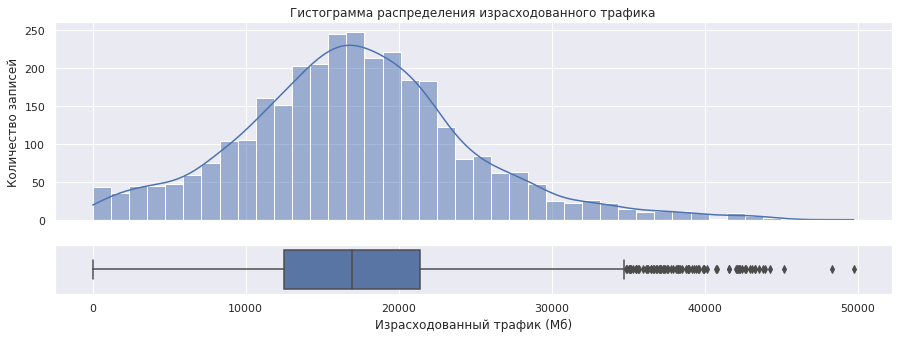

In [71]:
f, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 5), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[4,1]))
sns.histplot(data=df, x='mb_used', kde=True, ax=axs_hist)\
.set(title='Гистограмма распределения израсходованного трафика',
     ylabel='Количество записей')
sns.boxplot(data=df, x='mb_used', ax=axs_box)\
.set(xlabel='Израсходованный трафик (Мб)');

### _is_ultra_

Оценим баланс данных в колонке `is_ultra`.

In [72]:
df.is_ultra.value_counts(normalize=True).to_frame()

,is_ultra
0,0.693528
1,0.306472


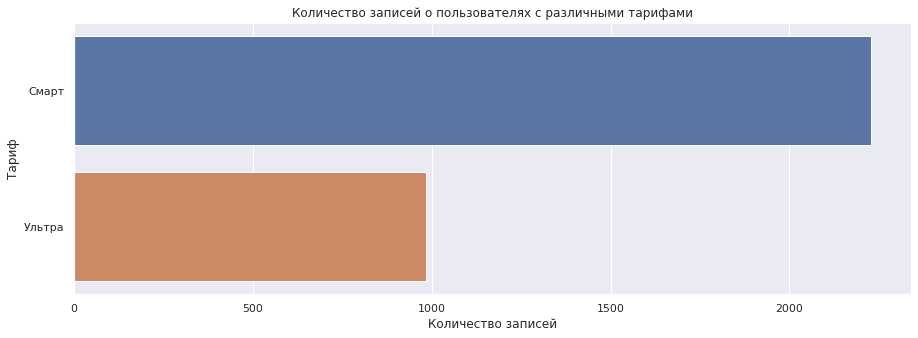

In [73]:
ax = sns.countplot(data=df, y='is_ultra')
ax.set(xlabel='Количество записей',
     ylabel='Тариф',
     title='Количество записей о пользователях с различными тарифами')
ax.set_yticklabels(['Смарт', 'Ультра']);

### Вывод

После загрузки и предварительного изучения данных каких-либо существенных проблем выявлено не было. На графиках boxplot видно некоторое количество выбросов, но эта ситуация вполне нормальна. Из гистограммы для колонки `is_ultra` видно, что данных о пользователях тарифа _smart_ у нас больше, чем данных о пользователях тарифа _ultra_.

## Разбиение данных на выборки

Итак, нам надо решить задачу классификации. Для этого необходимо разделить наши данные на две части: параметры и целевые данные. Так как мы будем классифицировать клиентов на потенциальных пользователей тарифов _ultra_ и _smart_, то в качестве целевых данных будем использовать колонку `is_ultra`. Все остальные данные будут параметрами.

In [74]:
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']

Теперь из данных необходимо выделить тестовую выборку. Для разделения выборок удобно воспользоваться фукнцией _train_test_split_ библиотеки _sklearn_. Для тестовой выборки возьмём 25% наших данных.

In [75]:
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=.75, 
                                                    random_state=42, stratify=target)

In [76]:
print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (2410, 4) (2410,)
Test: (804, 4) (804,)


## Исследование моделей

Давайте проведём несколько экспериментов с имеющимися данными. Обучим и проверим несколько моделей с разными гипер-параметрами и посмотрим какая из моделей лучше подходит для нашей задачи. 

Начнём, пожалуй, с решающего дерева, потом посадим случайный лес, а на закуску оставим логистическую регрессию. Все модели мы ранее загрузили из библиотеки _sklearn_, гипер-параметры для каждой модели подробно описаны в документации библиотеки.

Модели будем оценивать по метрике _accuracy_.

### Решающее дерево _(decision tree)_

Для нахождения наилучшего решающего дерева для нашей задачи проверим следующие диапазоны гипер-параметров:
* максимальная глубина дерева _(max_depth)_ от 1 до 30;
* минимальное количество объектов для ветвления _(min_samples_split)_ от 2 до 5.

In [77]:
%%time
params = {'max_depth': range(1, 31),
         'min_samples_split': range(2, 6)}
dtc = DecisionTreeClassifier(random_state=42)

best_dtc = GridSearchCV(estimator=dtc, param_grid=params, scoring='accuracy')
best_dtc.fit(X_train, y_train)
best_params_dtc = best_dtc.best_params_
best_score_dtc = best_dtc.best_score_

CPU times: user 7.16 s, sys: 12.5 ms, total: 7.17 s
Wall time: 7.17 s


In [78]:
print("Accuracy наилучшей модели на валидационной выборке:", round(best_score_dtc, 3), '\n',
      "Глубина дерева:", best_params_dtc['max_depth'], '\n',
      "Минимальное количество объектов для ветвления:", best_params_dtc['min_samples_split'])

Accuracy наилучшей модели на валидационной выборке: 0.796 
 Глубина дерева: 7 
 Минимальное количество объектов для ветвления: 4


Итак, применив одно решающее дерево мы получили на валидационных данных метрику _accuracy_ 0,796. Эта метрика была получена для дерева глубиной 7.

### Случайный лес _(random forest)_

Для нахождения наилучшего случайного леса для нашей задачи проверим следующие диапазоны гипер-параметров:
* количество деревьев в лесе _(n_estimators)_ от 80 до 120;
* максимальная глубина деревьев _(max_depth)_ от 5 до 20;
* минимальное количество объектов для ветвления _(min_samples_split)_ от 2 до 5.

In [79]:
%%time
params = {'max_depth': range(1, 31),
         'min_samples_split': range(2, 6),
         'n_estimators': range(80, 130, 10)}
rfc = RandomForestClassifier(random_state=42)

best_rfc = GridSearchCV(estimator=rfc, param_grid=params, scoring='accuracy', n_jobs=-1)
best_rfc.fit(X_train, y_train)
best_params_rfc = best_rfc.best_params_
best_score_rfc = best_rfc.best_score_

CPU times: user 21.5 s, sys: 1.18 s, total: 22.7 s
Wall time: 15min 44s


In [80]:
print("Accuracy наилучшей модели на валидационной выборке:", round(best_score_rfc, 3), '\n',
      "Количество деревьев в лесу:", best_params_rfc['n_estimators'], '\n',
      "Глубина дерева:", best_params_rfc['max_depth'], '\n',
      "Минимальное количество объектов для ветвления:", best_params_rfc['min_samples_split'])

Accuracy наилучшей модели на валидационной выборке: 0.802 
 Количество деревьев в лесу: 120 
 Глубина дерева: 13 
 Минимальное количество объектов для ветвления: 5


Итак, применив случайный лес решающих деревьев мы получили на валидационных данных метрику _accuracy_ 0,802. Эта метрика была получена для леса из 120 деревьев глубиной 13.

### Логистическая регрессия _(logit classifier)_

Построим логистическую регрессию с решателем _lbfgs_ и посмотрим на среднеквадратическую ошибку для неё.

In [81]:
%%time
params = {'solver': ['lbfgs'],
         'C': [0.8, 0.9, 1.0]}

lr = LogisticRegression(random_state=42)

best_lr = GridSearchCV(estimator=lr, param_grid=params, scoring='accuracy', n_jobs=-1)
best_lr.fit(X_train, y_train)
best_params_lr = best_lr.best_params_
best_score_lr = best_lr.best_score_

CPU times: user 129 ms, sys: 36.6 ms, total: 165 ms
Wall time: 471 ms


In [82]:
print("Accuracy наилучшей модели на валидационной выборке:", round(best_score_lr, 3), '\n',
      "Параметр регуляризации:", best_params_lr['C'])

Accuracy наилучшей модели на валидационной выборке: 0.721 
 Параметр регуляризации: 0.8


Итак, применив логистическую регрессию мы получили на валидационных данных метрику _accuracy_ 0,721. Маловато будет!

Построим сводный график с результатами кросс-валидации.

In [83]:
cv_dt = DecisionTreeClassifier(random_state=42, **best_params_dtc)

In [84]:
cv_rf = RandomForestClassifier(random_state=42, **best_params_rfc)

In [85]:
cv_lr = LogisticRegression(random_state=42, **best_params_lr)

In [86]:
scores = []

In [87]:
scores.append(cross_val_score(cv_dt, X_train, y_train, scoring='accuracy', cv=10))
scores.append(cross_val_score(cv_rf, X_train, y_train, scoring='accuracy', cv=10))
scores.append(cross_val_score(cv_lr, X_train, y_train, scoring='accuracy', cv=10))

In [88]:
scores = pd.DataFrame(scores, index=['Решающее дерево', 'Случайный лес', 'Логистическая регрессия'])

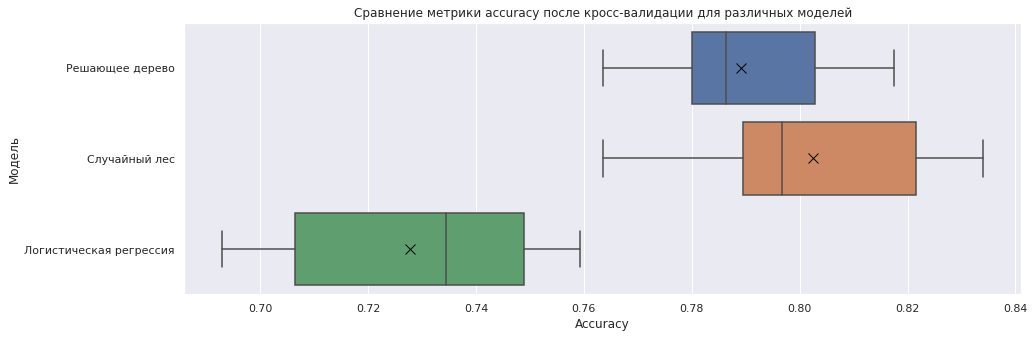

In [89]:
sns.boxplot(data=scores.T, orient='h', showmeans=True, 
                    meanprops={'marker': 'x',
                               'markeredgecolor': 'black',
                               'markersize': '10'})\
.set(title='Сравнение метрики accuracy после кросс-валидации для различных моделей',
     xlabel='Accuracy',
     ylabel='Модель');

### Вывод

Мы провели несколько экспериментов с различными моделями и различными наборами гипер-параметров. Модели сравнивали модели по метрике _accuracy_ на валидационных данных. Лучше всего себя показал случайный лес из 120 деревьев (метрика _accuracy_ 0,802, довольно неплохо).

| Модель         | Accuracy     | 
|--------------|-----------:|
| Решающее дерево | 0,796      | 
| Случайный лес      | 0,802  | 
| Логистическая регрессия      | 0,721 | 

## Проверка модели на адекватность

Убедимся, что выбранная нами модель действительно даёт стоящие прогнозы.

На этапе предварительного изучения данных мы заметили, что в нашей таблице пользователей тарифа _smart_ в два с лишним раза больше, чем пользователей тарифа _ultra_. А это значит, что если бы мы создали модель, которая всех пользователей просто относила бы к тарифу _smart_, то её метрика _accuracy_ была бы довольно неплохой (модель была бы права в более чем половине случаев). Посчитаем метрику _accuracy_ для такой модели и сравним с метрикой случайного леса.

In [90]:
dc = DummyClassifier(strategy='most_frequent')
dc.fit(X_train, y_train)

dummy_pred_test = dc.predict(X_test)
dummy_accuracy = accuracy_score(y_test, dummy_pred_test)
print('Метрика accuracy на тестовых данных:', round(dummy_accuracy, 3))

Метрика accuracy на тестовых данных: 0.694


**Вывод**

Как видно, если бы мы создали модель, которая всех пользователей относила к классу _smart_, то метрика _accuracy_ такой модели на тестовых данных была бы равна 0,694. Ранее выбранная нами модель случайного леса обеспечивала точность прогнозов на кросс-валидации 0,802, что заметно больше. При этом следует понимать, что столь высокая точность «глупой» модели обеспечивается за счёт того, что данных о пользователях тарифа _smart_ существенно больше. Если бы в данных пользователи обоих тарифов были представлены одинаково, точность «глупой» модели снизилась бы до ~0,5.

Отдельно стоит отметить, что в зависимости от цели моделирования может меняться и метрика. Например, если бизнесу необходима модель, которая бы с высокой точностью находила именно потенциальных пользователей тарифа _ultra_ (предположим, что он более выгодный), то следовало бы изменить метрику. В этом случае эффективность «глупой» модели, относящей всех к тарифу _smart_ была бы просто нулевой.

| Модель         | Accuracy     | 
|--------------|-----------:|
| Решающее дерево | 0,796      | 
| Случайный лес      | 0,802  | 
| Логистическая регрессия      | 0,721 | 
| Проверка на адекватность      | 0,694 | 

## Проверка модели на тестовой выборке

Проверим, как выбранный случайный лес покажет себя на тестовой выборке.

In [91]:
pred_test = best_rfc.predict(X_test)
ultimate_accuracy = accuracy_score(y_test, pred_test)
print('Метрика accuracy на тестовых данных:', ultimate_accuracy)

Метрика accuracy на тестовых данных: 0.8121890547263682


**Вывод**

Отобранная модель при проверке на тестовых данных показывает уровень _accuracy_ 0,812, что даже больше, чем на валидационных данных. В контексте задачи этот результат можно считать достаточно хорошим.

## Общий вывод по проекту

Целью данного проекта была разработка модели, позволяющей рекомендовать тариф _smart_ или _ultra_ для пользователей старых тарифов. 

Для этого использовались данные о клиентах, уже подключенных к тарифам _smart_ и _ultra_. Данные были разделены на обучающую и тестовую выборки.

Мы провели серию экспериментов с различными моделями и различными наборами гипер-параметров. Все модели сравнивались между собой по метрике _accuracy_ на кросс-валидации. Анализ показал, что для имеющегося набора данных наилучший результат показывает модель случайного леса из 120 деревьев глубиной 13.

Выбранная модель была проверена на тестовых данных, при этом метрика _accuracy_ составила 0,812, что в рамках данной задачи можно считать весьма хорошим результатом.

Данная модель позволит отбирать пользователей, которые готовы перейти на более выгодный для компании тариф и разрабатывать для них таргетированную рекламу, что может существенно снизить расходы бизнеса.